In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import joblib
import logging
import time
from pathlib import Path


logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
sns.set_style('darkgrid')

In [2]:
data_folder = Path('../data')
df_orig = pd.read_csv(data_folder / 'internet_service_churn.csv')
df_orig

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


Розділемо датасет на 2 частини:  
* одна для фінального тстування та завантаження в Streamlit - 500 рядків 
* друга буде використовуватися для аналізу та тренування моделей

In [37]:
df_final_test = df_orig.loc[:500,:].copy()
df_final_test.to_csv(data_folder / 'test_internet_service_churn.csv', index=False)
df = df_orig.loc[500:,:].copy()

In [16]:
df_final_test

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
496,10941,0,0,10.84,11,NaN,0,NaN,NaN,0,0
497,10977,1,1,10.83,22,NaN,0,20.2,2.2,0,0
498,11108,0,0,4.88,9,NaN,0,0.0,0.0,0,1
499,11120,0,0,6.38,0,NaN,0,0.2,0.0,0,1


Загальна інформація  по датасету

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71774 entries, 500 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71774 non-null  int64  
 1   is_tv_subscriber             71774 non-null  int64  
 2   is_movie_package_subscriber  71774 non-null  int64  
 3   subscription_age             71774 non-null  float64
 4   bill_avg                     71774 non-null  int64  
 5   reamining_contract           50553 non-null  float64
 6   service_failure_count        71774 non-null  int64  
 7   download_avg                 71408 non-null  float64
 8   upload_avg                   71408 non-null  float64
 9   download_over_limit          71774 non-null  int64  
 10  churn                        71774 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.0 MB


Бачимо що в деякіх колонках відсутні значення.  
5 ствбчик, що означає час до закінчення контракту та 7 і 8 стовбчики  - містить NaN значення.

Подивимось на іх кількість

In [5]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21221
service_failure_count              0
download_avg                     366
upload_avg                       366
download_over_limit                0
churn                              0
dtype: int64

Значення NaN в 5 стовбчику означає, що клієнт не укладав контракту з компанією.  
Додамо новий стовбчик 'contract', в якому позначимо - мав клієнт контракт (1) чи ні (0)

In [242]:
df

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
500,11138,0,0,5.87,0,NaN,0,0.0,0.0,0,1
501,11159,0,0,7.13,0,0.00,0,7.8,0.7,0,1
502,11164,1,0,4.28,13,NaN,0,0.0,0.0,0,1
503,11195,1,0,10.77,25,1.76,1,28.0,2.9,0,0
504,11266,1,1,10.76,20,1.26,0,181.1,5.2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


In [4]:
df['contract'] = df['reamining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
df.insert(5, 'contract', df.pop('contract'))
df['reamining_contract'] = df['reamining_contract'].fillna(0)

Кількість значеннь NaN в стовбчиках 'download_avg' та 'upload_avg' становить менш ніж 0,5% від усіх значень.  
Видалимо  рядки з NaN значеннями - це не вплине суттєво на  загальні данні 

In [5]:
df.dropna(subset=['download_avg', 'upload_avg'], inplace=True, ignore_index=True)

Датасет виглядяє наступним чином:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71408 entries, 0 to 71407
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71408 non-null  int64  
 1   is_tv_subscriber             71408 non-null  int64  
 2   is_movie_package_subscriber  71408 non-null  int64  
 3   subscription_age             71408 non-null  float64
 4   bill_avg                     71408 non-null  int64  
 5   contract                     71408 non-null  int64  
 6   reamining_contract           71408 non-null  float64
 7   service_failure_count        71408 non-null  int64  
 8   download_avg                 71408 non-null  float64
 9   upload_avg                   71408 non-null  float64
 10  download_over_limit          71408 non-null  int64  
 11  churn                        71408 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 6.5 MB


Перевіримо данні на наявність дублікатів

In [9]:
df[df.duplicated()]

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,contract,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn


Подивимось на статистичні данні

In [7]:
df.iloc[:, 1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,71408.0,0.817401,0.386340,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,71408.0,0.334724,0.471897,0.00,0.00,0.00,1.00,1.00
subscription_age,71408.0,2.414696,1.960942,-0.02,0.93,1.98,3.25,11.42
bill_avg,71408.0,19.030389,13.159953,0.00,13.00,19.00,22.00,406.00
contract,71408.0,0.703409,0.456758,0.00,0.00,1.00,1.00,1.00
reamining_contract,71408.0,0.499541,0.666329,0.00,0.00,0.00,1.03,2.92
service_failure_count,71408.0,0.275277,0.817090,0.00,0.00,0.00,0.00,19.00
download_avg,71408.0,43.834906,63.285856,0.00,6.90,28.00,60.70,4415.20
upload_avg,71408.0,4.207181,9.838175,0.00,0.50,2.10,4.90,453.30
download_over_limit,71408.0,0.208926,1.000077,0.00,0.00,0.00,0.00,7.00


Данні портібно буде стандартизовувати оскільки присутня розбіжніжсь числових значень

----

Виділимо ознаки(features) та цільову ознаку(target)

In [8]:
y = df['churn']
X = df.drop(columns=['churn','id'])

Подивимось на збалансованість данних

In [9]:
print(y.value_counts())

churn
1    39679
0    31729
Name: count, dtype: int64


Розділемо данні на тренувальну та тестову вибірки.  
Враховуючи що є незбалансованість вирішено примінити oversample метод  SMOTE(Synthetic Minority Oversampling Technique)  
Для стандартизації данних будемо використовувати метод StandardScaler

In [12]:
x_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
print(np.unique(Y_train, return_counts=True))

(array([0, 1], dtype=int64), array([23797, 29759], dtype=int64))


In [82]:
oversample = SMOTE()
scaler = StandardScaler()

X_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, Y_train)
X_train_scaled_oversampled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(x_test)

X_train = X_train_scaled_oversampled
X_test = X_test_scaled
y_train = y_train_oversampled

print(np.unique(y_train, return_counts=True))

print('train X', X_train.shape)
print('train y', y_train.shape)
print('test X', X_test.shape)
print('test y', y_test.shape)

(array([0, 1], dtype=int64), array([29759, 29759], dtype=int64))
train X (59518, 10)
train y (59518,)
test X (17852, 10)
test y (17852,)


Бачимо що тепер кількість данних для обох класів d тренувальній вибірці однакова

Збережемо SCALER в файл для можливості подальшого використання

In [15]:
joblib.dump(scaler,'../models/std_scaler_Serhii.pkl')

['../models/std_scaler_Serhii.pkl']

----

## Побудова моделей

Функція аналізу роботи моделей

In [16]:
def model_info(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of LR : {accuracy}")
    print('\n','-'*50)
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('\n','-'*50)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=900, vmax=6000)
    plt.title('Confusion matrix')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

Підбирати найкращі гіперпараметри будемо за допомогою GridSearchCV

### Logistic regression

In [83]:
lr_start_time = time.time()

LR = LogisticRegression(random_state=42)
param_grid = {'penalty':[None, 'l1', 'l2'],
              'C': [0.01, 0.001], 
              'max_iter':[20, 25, 30], 
              'solver': ['lbfgs', 'liblinear']
              }

logisticRegression = GridSearchCV(LR, param_grid, cv=3, refit=True, return_train_score=True, n_jobs=1)
logisticRegression.fit(X_train, y_train)
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

lr_model = logisticRegression.best_estimator_

y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
lr_end_time = time.time()-lr_start_time
print(f'Build Logistic Regression model time: {lr_end_time:.2f} secs')

c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_rati

Logistic Regression best parameters: {'C': 0.001, 'max_iter': 20, 'penalty': 'l2', 'solver': 'lbfgs'}
Build Logistic Regression model time: 7.40 secs


c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\serge\AppDa

In [73]:
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

Logistic Regression best parameters: {'C': 0.001, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}


Статистика роботи моделі LogisticRegression на тестувальних данних 

Accuracy of LR : 0.8828702666367914

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7932
           1       0.89      0.90      0.90      9920

    accuracy                           0.88     17852
   macro avg       0.88      0.88      0.88     17852
weighted avg       0.88      0.88      0.88     17852


 --------------------------------------------------


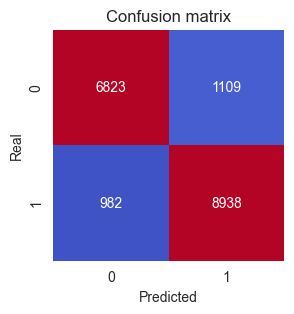

In [84]:
model_info(y_test, y_pred_lr)

Точність 88% не дуже гарний результат, але швидкість 6 секунд для всього процесу аналізу. Збережемо модель.

In [63]:
joblib.dump(lr_model,'../models/LR_model_Serhii.pkl')

['../models/LR_model_Serhii.pkl']

### LinearSVC

In [85]:
SVC = LinearSVC(random_state=42)

svc_start_time = time.time()
param_grid = {'C': [0.01, 0.1, 1], 'tol':[1e-4, 1e-05], 'max_iter':[1000, 10000]}
linearSVC = GridSearchCV(SVC, param_grid, cv=3, return_train_score=True, n_jobs=1)

linearSVC.fit(X_train, y_train)
print(f'LinearSVC best parameters: {linearSVC.best_params_}')

svc_model = linearSVC.best_estimator_
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

svc_end_time = time.time()-svc_start_time
print(f'Build LinearSVC model time: {svc_end_time:.2f} secs')

LinearSVC best parameters: {'C': 0.01, 'max_iter': 1000, 'tol': 0.0001}
Build LinearSVC model time: 4.84 secs


Статистика роботи моделі LinearSVC на тестувальних данних 

Accuracy of LR : 0.8797893793412502

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7932
           1       0.88      0.91      0.89      9920

    accuracy                           0.88     17852
   macro avg       0.88      0.88      0.88     17852
weighted avg       0.88      0.88      0.88     17852


 --------------------------------------------------


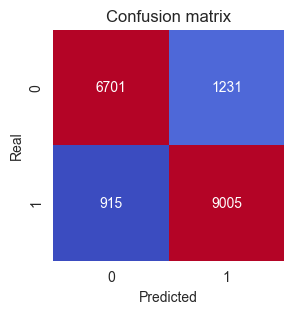

In [86]:
model_info(y_test, y_pred_svc)

Точність 88% як у Logistic Regression, але помилкових передбачень у класі '1' менше на 67 штук.  
Тобто модель трохи краще передбачила проблемних клієнтів.  
Збережемо модель.

In [62]:
joblib.dump(svc_model,'../models/SVC_model_Serhii.pkl')

['../models/SVC_model_Serhii.pkl']

----

### RandomForest

In [64]:
RF = RandomForestClassifier(random_state=42)

rf_start_time = time.time()
param_grid = {'n_estimators': [50, 100, 200], 'max_features':['sqrt', 'log2']}
RandomForest = GridSearchCV(estimator=RF, param_grid=param_grid, scoring='f1', cv=2, return_train_score=True, n_jobs=1, verbose=3)

RandomForest.fit(X_train, y_train)
print(f'RandomForest best parameters: {RandomForest.best_params_}')

rf_model = RandomForest.best_estimator_
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

rf_end_time = time.time()-rf_start_time
print(f'Build RandomForest model time: {rf_end_time:.2f} secs')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.940) total time=   3.6s
[CV 2/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.944) total time=   2.8s
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.941) total time=   6.9s
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.944) total time=   5.4s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.940) total time=  15.9s
[CV 2/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.945) total time=  13.7s
[CV 1/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.940) total time=   3.0s
[CV 2/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.944) total time=   2.6s
[CV 1/2] END max_features=log2, n_estimators=100;, score=(train=1.000, test=0.941) total time=   7.2s
[CV 2/2] END max_features=

Статистика роботи моделі на тестувальних данних

Accuracy of LR : 0.9397826574053327

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7932
           1       0.96      0.93      0.94      9920

    accuracy                           0.94     17852
   macro avg       0.94      0.94      0.94     17852
weighted avg       0.94      0.94      0.94     17852


 --------------------------------------------------


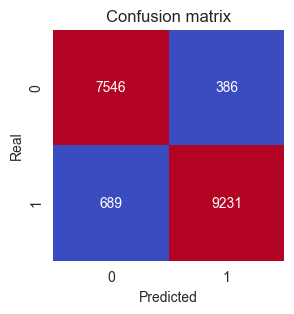

In [66]:
model_info(y_test, y_pred_rf)

Отримаємо чудовий результат 94% точності на тестувальній вибірці. Збережемо модель.

In [67]:
joblib.dump(rf_model,'../models/RF_model_Serhii.pkl', compress=3)

['../models/RF_model_Serhii.pkl']

Важливість ознак в датасеті для отриманої моделі

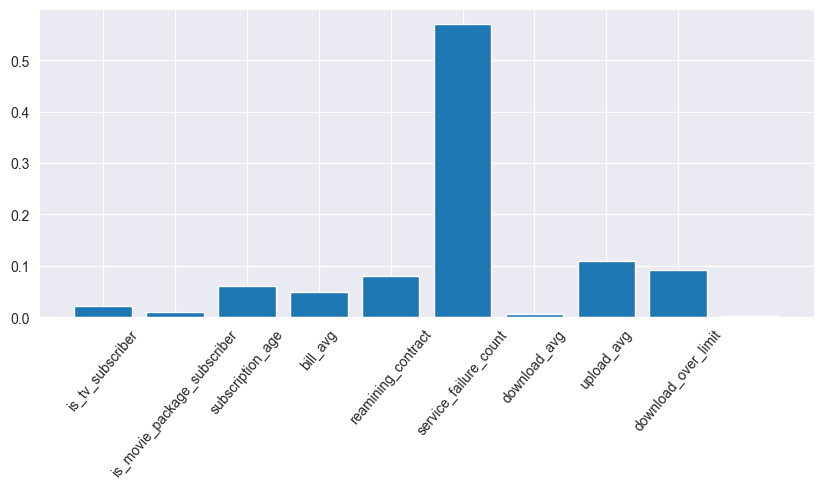

In [68]:
plt.figure(figsize=(10,4))
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.xticks(range(len(df.columns[1:-1])), df.columns[1:-1], rotation=50);

----

### Basic Neural Network

Побудуємо просту нейронну мережу.  
Розмірність данних змінемо за допомогою MinMaxScaler

In [29]:
min_max_scaler = MinMaxScaler()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
min_max_scaler.fit_transform(X)
X_train = min_max_scaler.transform(x_train)
X_test = min_max_scaler.transform(x_test)

In [30]:
model_NN = Sequential()
model_NN.add(Dense(128, input_dim=10, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(64, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(1, activation='sigmoid'))

model_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_NN.summary()

nn_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
history = model_NN.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

score = model_NN.evaluate(X_test, y_test, verbose=0)

pred = model_NN.predict(X_test)

nn_end_time = time.time()-nn_start_time
print(f'Build NN model time: {nn_end_time:.2f} secs')

c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8061 - loss: 0.4516 - val_accuracy: 0.8898 - val_loss: 0.3035
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8973 - loss: 0.3031 - val_accuracy: 0.9014 - val_loss: 0.2836
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9071 - loss: 0.2797 - val_accuracy: 0.9081 - val_loss: 0.2660
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9138 - loss: 0.2626 - val_accuracy: 0.9121 - val_loss: 0.2602
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9177 - loss: 0.2530 - val_accuracy: 0.9147 - val_loss: 0.2520
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9192 - loss: 0.2508 - val_accuracy: 0.9171 - val_loss: 0.2464
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9199 - loss: 0.2467 - val_accuracy: 0.9178 - val_loss: 0.2461
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9225 - loss: 0.2418 - val_accuracy: 0.

Статистика роботи моделі на тестувальних данних

Accuracy of LR : 0.9300918664575397

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      7932
           1       0.95      0.92      0.94      9920

    accuracy                           0.93     17852
   macro avg       0.93      0.93      0.93     17852
weighted avg       0.93      0.93      0.93     17852


 --------------------------------------------------


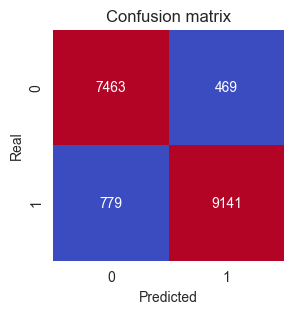

In [31]:
binary_predictions = [1 if p > 0.5 else 0 for p in pred]

model_info(y_test, binary_predictions)

Збережемо модель та скейлер

In [32]:
joblib.dump(model_NN,'../models/NN_model_Serhii.pkl')
joblib.dump(min_max_scaler,'../models/NN_scaler_Serhii.pkl')

['../models/NN_scaler_Serhii.pkl']

### Порівняємо роботу різних моделей

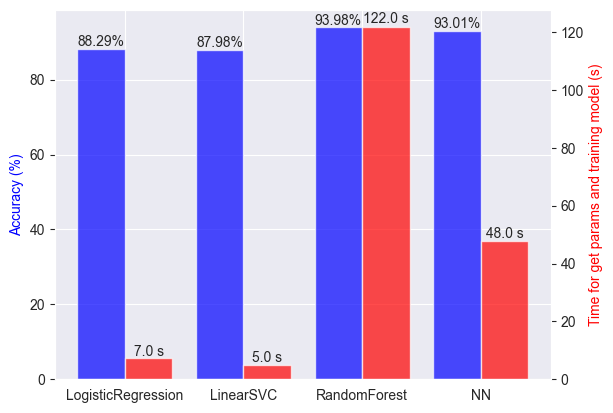

In [87]:
data = {'model':['LogisticRegression','LinearSVC', 'RandomForest', 'NN'],
        'analyze_time':[lr_end_time, svc_end_time, rf_end_time, nn_end_time],
        'accuracy':[accuracy_lr*100, accuracy_svc*100, accuracy_rf*100 ,score[1]*100]}

df_results = pd.DataFrame(data)

fig, ax= plt.subplots()
ax2 = ax.twinx()
width = 0.4

x = np.array([i for i,_ in enumerate(df_results['model'])])

ax.bar(x - width/2, df_results['accuracy'], color='b', alpha=0.7, width=width)
ax2.bar(x + width/2, df_results['analyze_time'], color='r', alpha=0.7, width=width)

plt.xticks(range(len(df_results['model'])), df_results['model'], rotation=0);
ax.set_ylabel('Accuracy (%)', color='b')
ax2.set_ylabel('Time for get params and training model (s)', color='r')

for i, v in enumerate(df_results['accuracy'].round(2)):
    ax.text(i-0.2, v, str(v)+'%', ha='center', va='bottom')

for i, v in enumerate(df_results['analyze_time'].round()):
    ax2.text(i+0.2, v, str(v)+' s', ha='center', va='bottom')

plt.grid()
plt.show()

Зробимо фінальне тестування

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


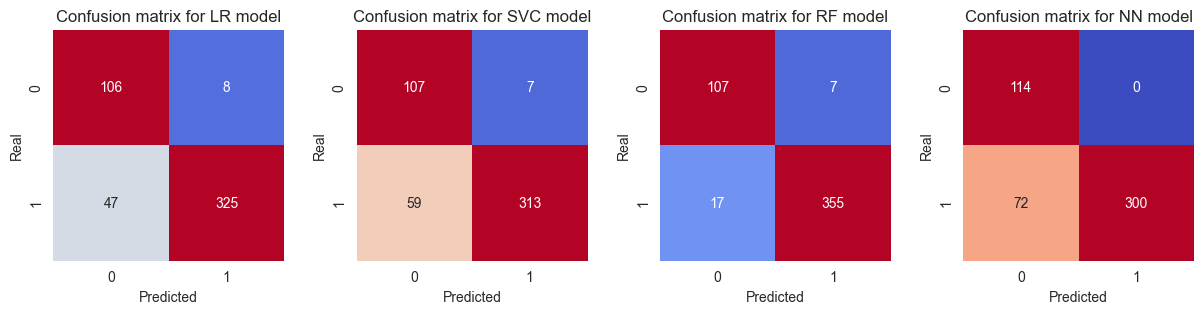

In [88]:
df_final_test['contract'] = df_final_test['reamining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
df_final_test.insert(5, 'contract', df_final_test.pop('contract'))
df_final_test['reamining_contract'] = df_final_test['reamining_contract'].fillna(0)
df_final_test.dropna(subset=['download_avg', 'upload_avg'], inplace=True, ignore_index=True)

data = df_final_test.drop(columns=['churn'])
features = data.drop(columns=['id'])
target = df_final_test['churn']
ids = data['id']
y_pred_lr = lr_model.predict(scaler.transform(features))
y_pred_svc = svc_model.predict(scaler.transform(features))
y_pred_rf = rf_model.predict(scaler.transform(features))
y_pred_nn =[1 if p > 0.5 else 0 for p in model_NN.predict(min_max_scaler.transform(features))]

pred = {'LR':y_pred_lr, 'SVC':y_pred_svc, 'RF':y_pred_rf, 'NN':y_pred_nn}

plt.figure(figsize=(15, 3))
for i, (m, p) in enumerate(pred.items()):
    cm = confusion_matrix(target, p)
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=0, vmax=100)
    plt.title(f'Confusion matrix for {m} model')
    plt.ylabel('Real')
    plt.xlabel('Predicted');